In [2]:
from groundedPL.codificacion import ToPropositionalLogic
from groundedPL.logic_tester import LogicTester
parser = ToPropositionalLogic()

c:\Users\prestamour\Logica_proyecto-final\groundedPL\codificacion.py:38: SyntaxWarning: invalid escape sequence '\{'
  assert(len(sentence_lp.free()) == 0), f'Fórmula con variables libres: {sentence_lp}\n\{sentence_lp.free()}'


In [3]:
from itertools import product
import random

triplas = product(range(4), range(5), range(4))
#triplas = product(range(4), range(4), range(4))

for x, y, n in triplas:
    parser.parse(f'En({x}, {y}, {n})')

In [12]:
from groundedPL.logUtils import LogUtils
from typing import List, Tuple
NUM_FILAS = 4
NUM_COLUMNAS = 4


def barco_h(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos horizontales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales horizontales
    inicio_min = max(0, x - n + 1)
    inicio_max = x
    
    for inicio_x in range(inicio_min, inicio_max + 1):
        casillas = [(inicio_x + i, y) for i in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cx < NUM_FILAS for cx, _ in casillas):
            barcos.append(casillas)
    
    return barcos


def barco_v(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos verticales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales verticales
    inicio_min = max(0, y - n + 1)
    inicio_max = y
    
    for inicio_y in range(inicio_min, inicio_max + 1):
        casillas = [(x, inicio_y + j) for j in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cy < NUM_COLUMNAS for _, cy in casillas):
            barcos.append(casillas)
    
    return barcos

# Regla general: Barcos alineados horizontal o verticalmente Y todas las casillas entre inicio y fin de un barco deben estar ocupadas
def regla_general():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                # Generar todas las configuraciones válidas de barcos que pasan por (x,y)
                configuraciones = []
                
                # Barcos horizontales
                for barco in barco_h(x, y, n):
                    # Construir conjunción: todas las casillas del barco + negaciones externas
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                                clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                    configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Barcos verticales
                for barco in barco_v(x, y, n):
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                               clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))


                    configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Construir la implicación manualmente
                if configuraciones:
                    antecedente = parser.to_nltk(f"En({x},{y},{n})")
                    consecuente = LogUtils.Otoria(configuraciones)
                    implicacion = f"({antecedente} -> ({consecuente}))"
                    #implicacion = f"(({antecedente} -> ({consecuente})) & (({consecuente}) -> {antecedente}))"
                    condiciones.append(parser.to_nltk(implicacion))
    
    return LogUtils.Ytoria(condiciones)

# Regla 4: No superposición de barcos
def crear_regla_4():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                negaciones = []
                for m in range(1, 5):
                    if m != n:
                        negaciones.append(parser.to_nltk(f"-En({x},{y},{m})"))
                antecedente = f"En({x},{y},{n})"    
                consecuente = LogUtils.Ytoria(negaciones)
                implicacion = f"({antecedente}) -> ({consecuente})"
                condiciones.append(parser.to_nltk(implicacion))
    return LogUtils.Ytoria(condiciones)

# Opcion A: Crear una regla del tablero donde le paso la interpretacion que tenga mi informacion parcial 
# Opcion B: Es darle manualmente la informacion de todo el tablero 

barcos = [(2, 1, 1), (0, 2, 2), (2, 0, 3),(1, 3, 4)]

def regla_tablero_en():
    literales = []
    for x, y, n in barcos:
        literales.append(parser.to_nltk(f"En({x},{y},{n})"))
    print("Barcos en tablero")
    for x, y, n in barcos:
        print(f"Barco de tamaño {n} en ({x}, {y})")
    return literales

def reglas():
    r = []
    print("Regla 1")
    r.append(regla_general())
    #print(regla_general())

    print("Regla No Superposición")
    r.append(crear_regla_4())
    #print(crear_regla_4())

    print("Regla Tablero")
    r.extend(regla_tablero_en())
    #print(regla_tablero_en())
    
    return LogUtils.Ytoria(r)

reglas()



Regla 1
Regla No Superposición
Regla Tablero
Barcos en tablero
Barco de tamaño 1 en (2, 1)
Barco de tamaño 2 en (0, 2)
Barco de tamaño 3 en (2, 0)
Barco de tamaño 4 en (1, 3)


<AndExpression ((En(0,0,1) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)))) & (En(0,0,2) -> ((En(0,0,2) & En(1,0,2) & -En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)) | (En(0,0,2) & En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,0,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)))) & (En(0,0,3) -> ((En(0,0,3) & En(1,0,3) & En(2,0,3) & -En(0,1,3) & -En(0,2,3) & -En(0,3,3) & -En(1,1,3) & -En(1,2,3) &

In [13]:

print(barcos)

[(2, 1, 1), (0, 2, 2), (2, 0, 3), (1, 3, 4)]


---

# Visualización de interpretaciones <a class="anchor" id="visual"></a>

([Volver al inicio](#inicio))



In [14]:
"""I = {
    #parser.parse("En(1,0,1)"): True,
    parser.parse("En(0,1,2)"): True,
    #parser.parse("En(2,0,3)"): True,
    #parser.parse("En(3,0,4)"): True,
}"""



'I = {\n    #parser.parse("En(1,0,1)"): True,\n    parser.parse("En(0,1,2)"): True,\n    #parser.parse("En(2,0,3)"): True,\n    #parser.parse("En(3,0,4)"): True,\n}'

In [15]:
"""condicion_inicial = LogUtils.Ytoria([parser.to_nltk(parser.leer(letra)) for letra in I.keys()])
condicion_inicial"""

'condicion_inicial = LogUtils.Ytoria([parser.to_nltk(parser.leer(letra)) for letra in I.keys()])\ncondicion_inicial'

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualizar_batalla_naval(I: dict):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, NUM_COLUMNAS-0.5)
    ax.set_ylim(-0.5, NUM_FILAS-0.5)
    ax.set_xticks(range(NUM_COLUMNAS))
    ax.set_yticks(range(NUM_FILAS))
    ax.grid(True, linewidth=0.0)
    ax.invert_yaxis()

    colores = {
        'destapada': '#2196F3',
        'tapada': "#FFFFFF",
        'barco': "#C05321"
    }

    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            rect = patches.Rectangle(
                (y-.5, x-0.5), 1, 1,
                facecolor=colores['tapada'],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)

    barco_size = 0.7  # tamaño relativo del barco (menos de 1)
    offset = (1 - barco_size) / 2

    for letra, value in I.items():
        if value:
            x, y, n = parser.obtener_argumentos(letra)
            x, y, n = int(x), int(y), int(n)
            rect = patches.Rectangle(
                (y-0.5 + offset, x-0.5 + offset), barco_size, barco_size,
                facecolor=colores['barco'],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)
            ax.text(
                y, x, str(n),
                ha='center', va='center',
                color='white', fontsize=12,
                weight='bold'
            )

    plt.title("Batalla Naval - Modo Parcial")
    plt.show()

In [55]:
def barcos_a_dict(barcos):
    return {parser.parse(f"En({x},{y},{n})"): True for x, y, n in barcos}

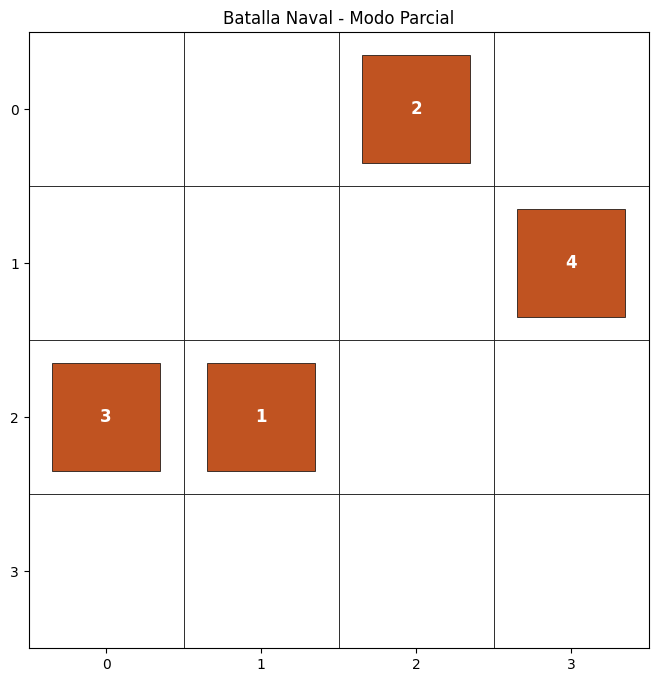

In [56]:
visualizar_batalla_naval(barcos_a_dict(barcos))

Regla 1
Regla No Superposición
Regla Tablero
Barcos en tablero
Barco de tamaño 1 en (2, 1)
Barco de tamaño 2 en (0, 2)
Barco de tamaño 3 en (2, 0)
Barco de tamaño 4 en (1, 3)
SAT resultado: [1, 2, -3, -4, -5, 6, -7, -8, 9, -10, -11, 12, -13, -14, 15, -16, -17, 18, -19, -20, 21, -22, -23, 24, -25, -26, -27, 28, -29, 30, -31, -32, 33, -34, -35, 36, -37, -38, 39, -40, -41, 42, -43, -44, 45, -46, -47, 48, -49, 50, -51, 52, -53, 54, -55, 56, -57, 58, -59, 60, -61, 62, -63, -64, -65, 66, -67, 68, -69, 70, -71, 72, -73, 74, -75, 76, -77, -78, 79, -80, -81, -82, 83, -84, -85, -86, 87, -88, 89, -90, -91, 92, -93, -94, -95, 96, -97, 98, -99, -100, 101, -102, -103, 104, -105, -106, 107, -108, -109, 110, -111, -112, 113, -114, -115, 116, -117, -118, 119, -120, -121, 122, -123, -124, -125, -126, -127, 128, -129, 130, -131, 132, -133, -134, -135, 136, -137, 138, -139, 140, -141, 142, -143, 144, -145, 146, -147, 148, -149, 150, -151, 152, -153, -154, 155, 156, -157, -158, 159, -160, 161, 162, -163, -

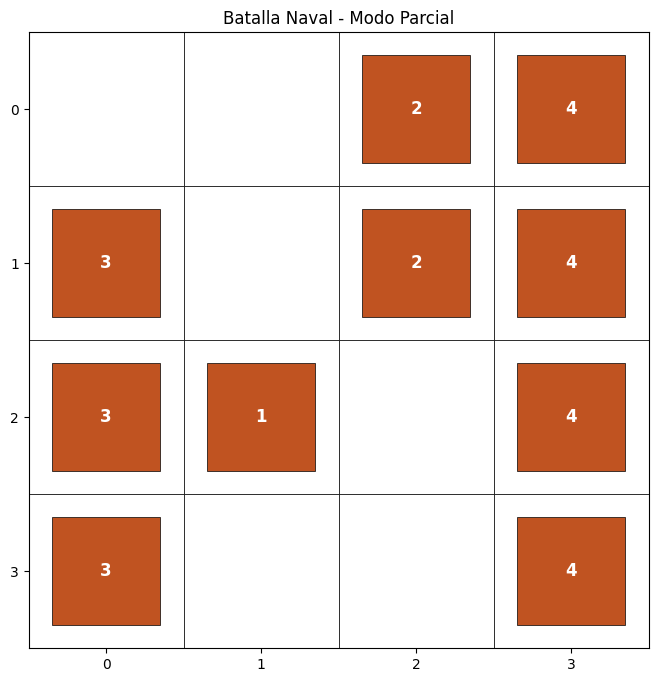

In [57]:
lt = LogicTester()
regla = reglas()
formula_lp = lt.translation_to_prover(regla)
res = lt.SATsolve(formula_lp)

print("SAT resultado:", res)
print("Formula: ", formula_lp)
if res == 'UNSAT':
    print('La fórmula es insatisfacible')
else:
    print('La fórmula es satisfacible')
    
    modelo = [lt.to_numeric.literal(x) for x in res]
    modelo = [x for x in modelo if lt.to_numeric.solo_atomo(x) in lt.tseitin.atomos]
    #print(f'\nModelo:\n\n\t{modelo}')

    modelo_decodificado = [lt.to_lp.modelo_lp.decodificar(x) for x in modelo]
    print(f'\nModelo decodificado:\n\n\t{modelo_decodificado}')


    condicion_inicial = parser.crear_interpretacion(modelo_decodificado)
    visualizar_batalla_naval(condicion_inicial)

